In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pprint
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
class FeatureEngineering():
    def __init__(self):
        self._cabinKnown = False
        self._title = False
        self._familySize = False
        self._isMinor = False
        self._isMinorThresh = 0

    def _familyCategorise(self, s):
        if s>= 4:
            return 'large'
        if s == 0:
            return 'alone'
        if s > 0 and s < 4:
            return 'normal'
    

    def cabinKnown(self, df):
        self._cabinKnown = True
        return pd.Categorical(df['Cabin'].isnull() == False)


    def title(self, df):
        self._title = True
        titles = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

        mr_alias = ['Don', 'Rev', 'Dr', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer']
        miss_alias = ['Mlle', 'Ms']
        mrs_alias = ['Mme', 'Lady', 'the Countess', 'Dona']

        titles[titles.isin(mr_alias)] = 'Mr'
        titles[titles.isin(miss_alias)] = 'Miss'
        titles[titles.isin(mrs_alias)] = 'Mrs'
        return titles.astype('category')


    def familySize(self, df):
        self._familySize = True
        family = df['Parch'] + df['SibSp']
        return pd.Categorical(list(map(self._familyCategorise, family)), ordered=True)


    def isMinor(self, df, threshold):
        # Try thresholds 14 and 9 to start off with, aim is to balanced 
        # maximising difference between groups while also capturing 
        # most information possible
        self._isMinor = True
        self._isMinorThresh = threshold
        return pd.Categorical(np.digitize(df['Age'], [threshold, 0]))


    def getSummary(self):
        s = "cabinKnown:\t\t{}\ntitle:\t\t\t{}\nfamilySize:\t\t{}\nisMinor (age < {}):\t{}".format(
            self._cabinKnown, self._title, self._familySize, self._isMinorThresh, self._isMinor)
        
        return s

In [3]:
FE = FeatureEngineering()
pp = pprint.PrettyPrinter(indent=4)

def engineer_features(df):
    print("Engineering Features...")
    ndf = df.copy()
    ndf['CabinKnown'] = FE.cabinKnown(ndf)
    ndf['Title'] = FE.title(ndf)
    ndf['FamilySize'] = FE.familySize(ndf)
    ndf['IsMinor'] = FE.isMinor(ndf, 14)
    print(''.join(['\t' + ln for ln in FE.getSummary().splitlines(True)]))
    return ndf


def fill_missing(df):
    print("Filling missing values ...")
    ndf = df.copy()
    # Fill missing Fare with median of the corresponding Passenger Class
    missing_fares = ndf[ndf['Fare'].isnull()].index.tolist()

    for fare in missing_fares:
        pclass = ndf.iloc[fare]['Pclass']
        ndf.set_value(fare, 'Fare', ndf[ndf['Pclass'] == pclass]['Fare'].mean())

    print('\tFare:\t\t\tMean of Corresponding Pclass')

    # Fill missing locations with most common
    missing_embarks = ndf[ndf['Embarked'].isnull()].index.tolist()
    mcl = ndf['Embarked'].value_counts().idxmax()
    for eb in missing_embarks:
        ndf.set_value(eb, 'Embarked', mcl)

    print('\tEmbarked:\t\tMode of Embarked')
    return ndf


def transform_features(df):
    print("Transforming features...")
    ndf = df.copy()
    ndf['Fare'] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    print("\tFare:\t\t\tlog")
    return ndf


def prep_data_for_tree_model(df):
    print("Prepping data for model training... no dummies, all cat to codes")
    ndf = pd.DataFrame(df['PassengerId'])
    # Pclass (ordered cat)
    ndf['Pclass'] = pd.to_numeric(df['Pclass'])
    # Sex (binary cat)
    ndf['IsMale'] = df['Sex'].cat.codes
    # Fare (num)
    ndf['Fare'] = df['Fare']
    # Embarked (unordered multilevel cat)
    ndf['Embarked'] = df['Embarked'].cat.codes
    # CabinKnown (binary cat)
    ndf['CabinKnown'] = df['CabinKnown'].cat.codes
    # Title (unordered multilevel cat)
    ndf['Title'] = df['Title'].cat.codes
    # FamilySize (ordered cat)
    ndf['FamilySize'] = df['FamilySize'].cat.codes
    # isMinor (binary cat)
    ndf['IsMinor'] = df['IsMinor'].cat.codes
    return ndf


def prep_data_for_sv_model(df):
    print("Prepping data for scale variant model training...")
    ndf = pd.DataFrame(df['PassengerId'])
    # Pclass (ordered cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Pclass'], prefix='Pclass')], axis=1)
    # Sex (binary cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Sex'], prefix='Sex')], axis=1)
    # Fare (num)
    ndf['Fare'] = df['Fare']
    # Embarked (unordered multilevel cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)
    # CabinKnown (binary cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['CabinKnown'], prefix='CabinKnown')], axis=1)
    # Title (unordered multilevel cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Title'], prefix='Title')], axis=1)
    # FamilySize (ordered multilevel cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['FamilySize'], prefix='FamilySize')], axis=1)
    # isMinor (binary cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['IsMinor'], prefix='IsMinor')], axis=1)
    return ndf


def coerce_types(df):
    ndf = df.copy()
    ndf.Pclass = ndf.Pclass.astype("category", categories=[1, 2, 3], ordered=True)
    ndf.Sex = ndf.Sex.astype("category")
    ndf.Embarked = ndf.Embarked.astype("category")
    return ndf


def naSummary(df):
    return df.isnull().sum()

In [4]:
train = pd.read_csv('../input/train_pp.csv')
test = pd.read_csv('../input/test_pp.csv')

combine = pd.concat([train.drop('Survived', 1), test])
combine.reset_index(inplace=True, drop=True) 
combine = coerce_types(combine)

combine = engineer_features(combine)
combine = fill_missing(combine)

combine = transform_features(combine)
combine_tree = prep_data_for_tree_model(combine)

combine_svm = prep_data_for_sv_model(combine)

X_train = combine_tree[:len(train)].drop('PassengerId', axis=1)
X_test = combine_tree[len(train):].drop('PassengerId', axis=1)
y_train = train['Survived']

Engineering Features...
	cabinKnown:		True
	title:			True
	familySize:		True
	isMinor (age < 14):	True
Filling missing values ...
	Fare:			Mean of Corresponding Pclass
	Embarked:		Mode of Embarked
Transforming features...
	Fare:			log
Prepping data for model training... no dummies, all cat to codes
Prepping data for scale variant model training...


In [5]:
seed = 7
folds = 10

skf = StratifiedKFold(n_splits=folds)

In [6]:
# RandomForest Tuning
rfc = RandomForestClassifier()

rfc_params = {
    "max_depth": [4, 5, 6, 7, 8],
    "warm_start": [False],
    "n_estimators": [150],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 3, 4, 5, 6],
    "random_state": [seed]
}

gsRFC = GridSearchCV(rfc, param_grid=rfc_params, cv=skf, n_jobs=-1, verbose=1)
_ = gsRFC.fit(X_train, y_train)

Fitting 10 folds for each of 125 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  1.1min finished


In [7]:
print("RFC Best Params:")
pp.pprint(gsRFC.best_params_)
pp.pprint("RFC best score: {}".format(gsRFC.best_score_))

RFC Best Params:
{   'max_depth': 7,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'n_estimators': 150,
    'random_state': 7,
    'warm_start': False}
'RFC best score: 0.8372615039281706'


In [8]:
# GradientBoost Tuning
gbc = GradientBoostingClassifier()

gbc_params = {
    "loss": ['deviance'],
    "learning_rate": [0.15, 0.1, 0.05],
    "n_estimators": [100, 200],
    "max_depth": [4, 5, 6, 7],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 3, 4, 5, 6],
    "random_state": [seed]
}

gsGBC = GridSearchCV(gbc, param_grid=gbc_params, cv=skf, n_jobs=-1, verbose=1)
_ = gsGBC.fit(X_train, y_train)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 1762 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2312 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2962 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3712 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4562 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5512 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  5.3min finished


In [9]:
print("GBC Best Params:")
pp.pprint(gsGBC.best_params_)
pp.pprint("GBC best score: {}".format(gsGBC.best_score_))

GBC Best Params:
{   'learning_rate': 0.1,
    'loss': 'deviance',
    'max_depth': 4,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 7}
'GBC best score: 0.8417508417508418'


In [10]:
# AdaBoost Tuning
abc = AdaBoostClassifier()

abc_params = {
    "n_estimators": [100, 200],
    "learning_rate": np.linspace(0.01, 1, num=100),
    "random_state": [seed]
}

gsABC = GridSearchCV(abc, param_grid=abc_params, cv=skf, n_jobs=-1, verbose=1)
_ = gsABC.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.1min finished


In [11]:
print("ABC Best Params:")
pp.pprint(gsABC.best_params_)
pp.pprint("ABC best score: {}".format(gsABC.best_score_))

ABC Best Params:
{'learning_rate': 0.17000000000000001, 'n_estimators': 200, 'random_state': 7}
'ABC best score: 0.835016835016835'


In [12]:
scores = pd.DataFrame(columns=['Model', 'CV Score'])

classifiers = {
    'RandomForest': gsRFC.best_estimator_,
    'AdaBoost': gsABC.best_estimator_,
    'GradientBoosting': gsGBC.best_estimator_
}

print("Scoring...  ", end='')
for c in classifiers:
    print(c, end='  ')
    mdl_scores = cross_val_score(classifiers[c], X=X_train, y=y_train, cv=skf, n_jobs=-1)
    scores = scores.append(pd.DataFrame({'Model': np.repeat(c, folds), 'CV Score': mdl_scores}))

Scoring...  RandomForest  AdaBoost  GradientBoosting  

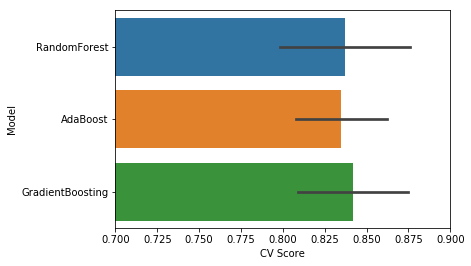

In [13]:
%matplotlib inline
p = sns.barplot(x='CV Score', y='Model', ci="sd", data=scores)
_ = p.set_xlim(0.7, 0.9)

In [14]:
vc = VotingClassifier(estimators=[
    ('rfc', gsRFC.best_estimator_),
    ('adac', gsABC.best_estimator_),
    ('gbc', gsGBC.best_estimator_)
    ], voting='soft', n_jobs=-1)

vc.fit(X_train, y_train)
vc_preds = vc.predict(X_test)

In [15]:
bestRFC = gsRFC.best_estimator_
bestABC = gsABC.best_estimator_
bestGBC = gsGBC.best_estimator_

bestRFC.fit(X_train, y_train)
bestABC.fit(X_train, y_train)
bestGBC.fit(X_train, y_train)

rf_preds = bestRFC.predict(X_test)
ab_preds = bestABC.predict(X_test)
gb_preds = bestGBC.predict(X_test)

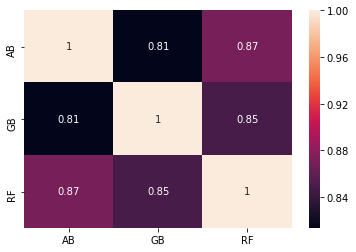

In [16]:
all_preds = pd.DataFrame({'RF': rf_preds, 'AB': ab_preds, 'GB': gb_preds})
_ = sns.heatmap(all_preds.corr(), annot=True)

In [17]:
vc_submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': vc_preds})
rf_submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': rf_preds})
ab_submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': ab_preds})
gb_submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': gb_preds})

vc_submit.to_csv("../output/vc_.csv", index=False)
rf_submit.to_csv("../output/rf_.csv", index=False)
ab_submit.to_csv("../output/ab_.csv", index=False)
gb_submit.to_csv("../output/gb_.csv", index=False)